In [34]:
import os
import torch
import pandas as pd
import itertools
import numpy as np
import ipywidgets as widgets
from napatrackmater.Trackvector import (
    SHAPE_DYNAMIC_FEATURES
)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

In [32]:
dataset_name = 'Sixth'
home_folder = '/home/debian/jz/'
channel = 'nuclei_'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tracklet_length = 25
normalized_dataframe = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}.csv')
print(f'reading data from {normalized_dataframe}')
tracks_dataframe = pd.read_csv(normalized_dataframe)
n_components = 5

class_map_gbr = {
        0: "Basal",
        1: "Radial",
        2: "Goblet"
    }

reading data from /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/dataframes/goblet_basal_dataframe_normalized_nuclei_.csv


In [33]:
all_trackmate_ids = [trackid  for trackid in tracks_dataframe['TrackMate Track ID'].unique()]
result_dict = {cell_type: {} for cell_type in class_map_gbr.values()}

unique_time_points = tracks_dataframe['t'].unique()

for time_point in unique_time_points:
        time_data = tracks_dataframe[tracks_dataframe['t'] == time_point]

        for cell_type in class_map_gbr.values():
            cell_type_data = time_data[time_data['Cell_Type'] == cell_type]

            if not cell_type_data.empty:
                
                features_list = []
                for track_id in cell_type_data['Track ID'].unique():
                    track_features = cell_type_data[cell_type_data['Track ID'] == track_id][SHAPE_DYNAMIC_FEATURES].to_numpy()
                    features_list.append(track_features)

                concatenated_features = np.vstack(features_list)
                
                if concatenated_features.shape[0] > n_components:  
                    pca = PCA(n_components=n_components)
                    principal_components = pca.fit_transform(concatenated_features)

                    if time_point not in result_dict[cell_type]:
                        result_dict[cell_type][time_point] = []

                    result_dict[cell_type][time_point].append(principal_components)


In [53]:
def plot_pcs_histogram(result_dict, class_map_gbr, n_components=5, selected_pc=1):
    # Ensure the selected_pc is within the range of n_components
    if selected_pc < 1 or selected_pc > n_components:
        print(f"Invalid principal component number. Please choose a number between 1 and {n_components}.")
        return

    # Plot histograms for the selected principal component (PC1, PC2, ..., PCn)
    for cell_type in class_map_gbr.values():
        if cell_type in result_dict:
            plt.figure(figsize=(10, 6))
            # Iterate over each time point
            for time_point in sorted(result_dict[cell_type].keys()):
                pcs_list = result_dict[cell_type][time_point]  # List of PC arrays for this time point
                pcs = np.vstack(pcs_list)  # Concatenate all PCs for this time point
                
                # Get the selected PC values for this time point
                pc_values = pcs[:, selected_pc - 1]  # Extract the selected PC values for all tracks

                # Plot the histogram of the selected PC values
                plt.hist(pc_values, bins=20, alpha=0.7, label=f'Time {time_point}')

            # Customize the plot
            plt.xlabel(f'PC{selected_pc} Value')
            plt.ylabel('Frequency')
            plt.title(f'Histogram of Principal Component {selected_pc} Over Time for {cell_type}')
           
            plt.tight_layout()
            plt.show()


            
def plot_pcs(result_dict, class_map_gbr, time_point):
    
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(class_map_gbr)))  
    
    plt.figure(figsize=(12, 6* n_components))
    
    pc_pairs = list(itertools.combinations(range(n_components), 2))

    for i, (cell_type, color) in enumerate(zip(class_map_gbr.values(), colors)):
        if cell_type in result_dict:
            pcs_list = []
            for time in result_dict[cell_type]:
                if time == time_point:
                    pcs = np.vstack(result_dict[cell_type][time])
                    pcs_list.append(pcs)
            
            if pcs_list:  
                pcs = np.vstack(pcs_list)
                
                for j, (pc1, pc2) in enumerate(pc_pairs):
                    plt.subplot(len(pc_pairs) // 2 + 1, 2, j + 1)
                    plt.scatter(pcs[:, pc1], pcs[:, pc2], color=color, alpha=0.7, label=cell_type)
                    plt.xlabel(f'PC{pc1+1}')
                    plt.ylabel(f'PC{pc2+1}')
                    plt.title(f'PC{pc1+1} vs PC{pc2+1} for {cell_type} at time {time_point}')
                    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()
    

# Interactive widget setup
def interactive_plot(result_dict, class_map_gbr, unique_time_points):
    interact(
        plot_pcs,
        result_dict=widgets.fixed(result_dict),
        class_map_gbr=widgets.fixed(class_map_gbr),
        time_point=IntSlider(min=min(unique_time_points), max=max(unique_time_points), step=1, description='Time Point:')
    )

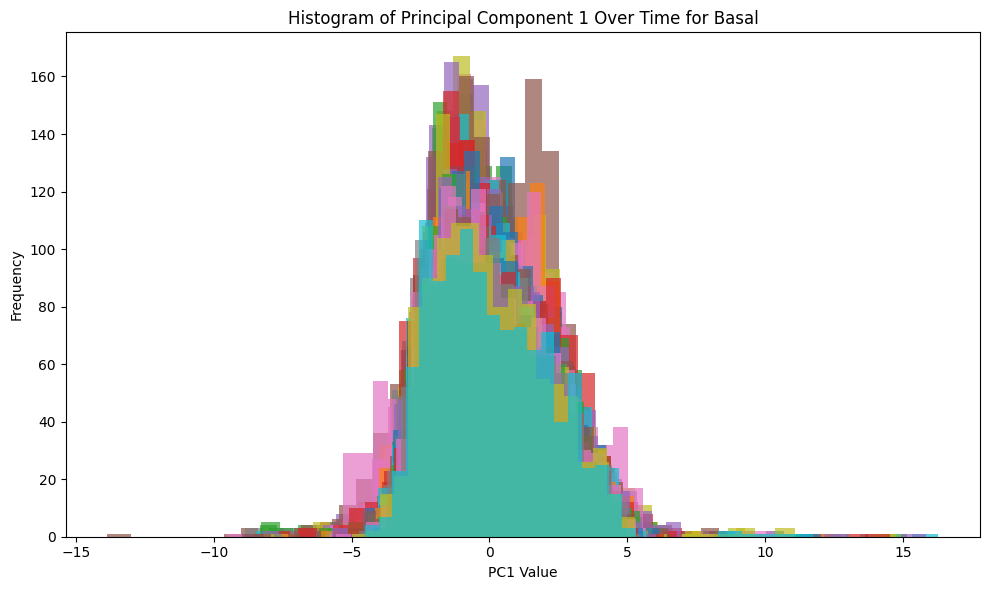

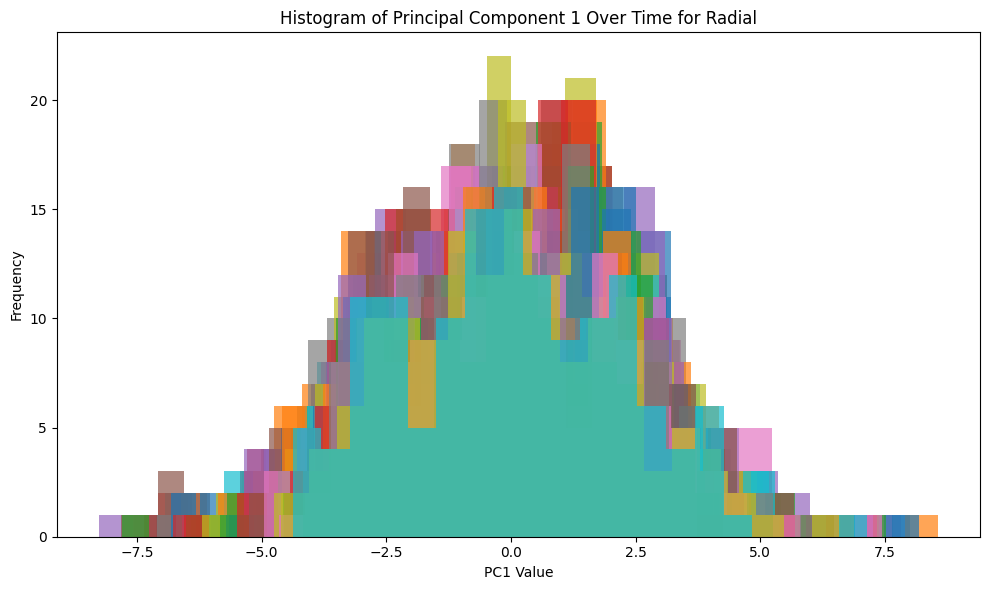

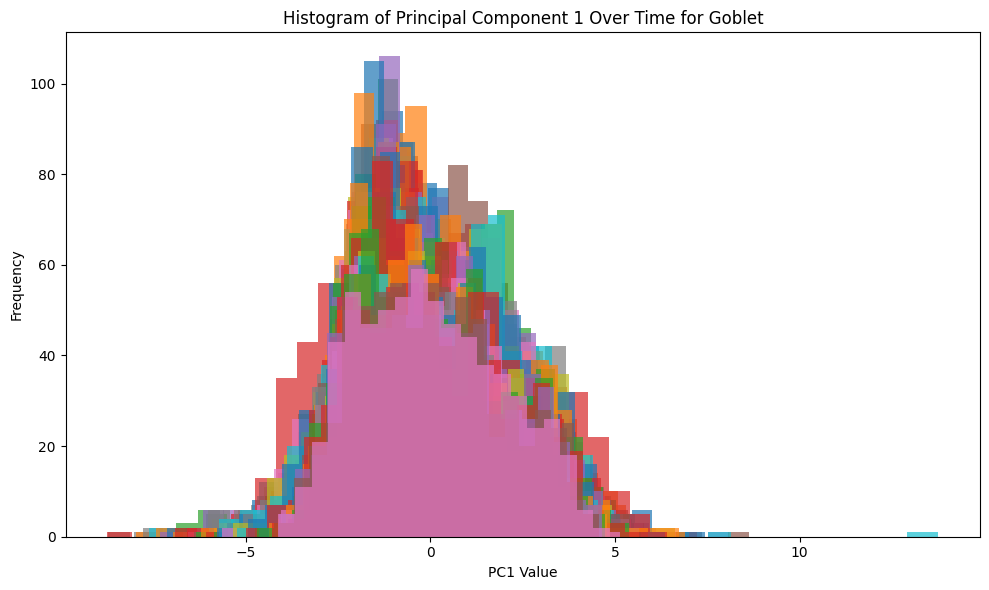

In [54]:
plot_pcs_histogram(result_dict, class_map_gbr, n_components)

In [42]:
interactive_plot(result_dict, class_map_gbr, tracks_dataframe['t'].unique())

interactive(children=(IntSlider(value=0, description='Time Point:', max=359), Output()), _dom_classes=('widget…